In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
#from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [2]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "C:\\Users\\MO\\Desktop\\Deep-Learning-For-Hackers-master\\data\\3.stock-prediction\\BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [3]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [4]:
df = df.sort_values('Date')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-10,4048.340088,4085.090088,3631.070068,3668.149902,3668.149902,412522198
1,2019-01-11,3668.149902,3729.689941,3616.409912,3669.199951,3669.199951,231465488
2,2019-01-12,3669.199951,3692.120117,3611.199951,3664.379883,3664.379883,103912541
3,2019-01-13,3664.379883,3675.199951,3528.239990,3551.239990,3551.239990,164125048
4,2019-01-14,3551.239990,3748.879883,3544.530029,3703.899902,3703.899902,204793029


In [6]:
df.shape

(102, 7)

Text(0, 0.5, 'Close Price (USD)')

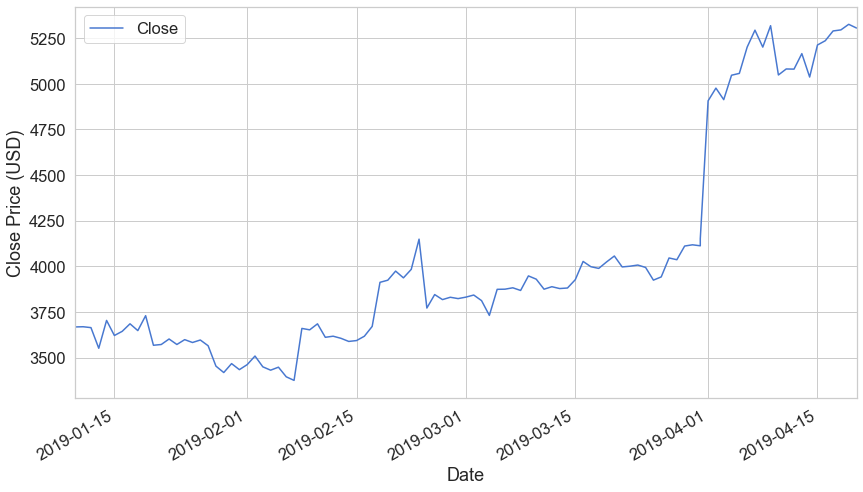

In [7]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [8]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [9]:
scaled_close.shape

(102, 1)

In [10]:
np.isnan(scaled_close).any()

False

In [11]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [12]:
scaled_close = scaled_close.reshape(-1, 1)

In [13]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [14]:
SEQ_LEN = 10

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [15]:
X_train.shape

(87, 9, 1)

In [16]:
X_test.shape

(5, 9, 1)

# Model

In [29]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [30]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [31]:
BATCH_SIZE = 5

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Train on 78 samples, validate on 9 samples
Epoch 1/100
78/78 [==============================] - 17s 217ms/sample - loss: 0.0250 - val_loss: 0.1524
Epoch 2/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0344 - val_loss: 0.1442
Epoch 3/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0225 - val_loss: 0.1301
Epoch 4/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0177 - val_loss: 0.0686
Epoch 5/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0161 - val_loss: 0.0373
Epoch 6/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0136 - val_loss: 0.0179
Epoch 7/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0115 - val_loss: 0.0187
Epoch 8/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0102 - val_loss: 0.0385
Epoch 9/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0098 - val_loss: 0.0670
Epoch 10/100
78/78 [=========================

Epoch 81/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0058 - val_loss: 0.0246
Epoch 82/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0058 - val_loss: 0.0266
Epoch 83/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0051 - val_loss: 0.0091
Epoch 84/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0064 - val_loss: 0.0201
Epoch 85/100
78/78 [==============================] - 0s 3ms/sample - loss: 0.0048 - val_loss: 0.0203
Epoch 86/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0056 - val_loss: 0.0159
Epoch 87/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0045 - val_loss: 0.0159
Epoch 88/100
78/78 [==============================] - 0s 3ms/sample - loss: 0.0050 - val_loss: 0.0080
Epoch 89/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0048 - val_loss: 0.0073
Epoch 90/100
78/78 [==============================] - 0s 2ms/sample - loss: 0.0058

In [32]:
model.evaluate(X_test, y_test)

5/1 [======================================================================================================================================================] - 0s 1ms/sample - loss: 1.0873e-04


0.00010873346764128655

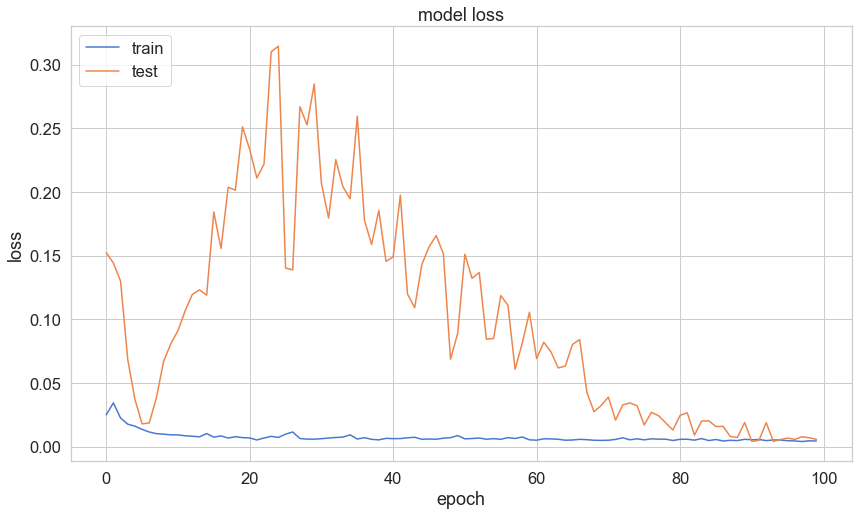

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

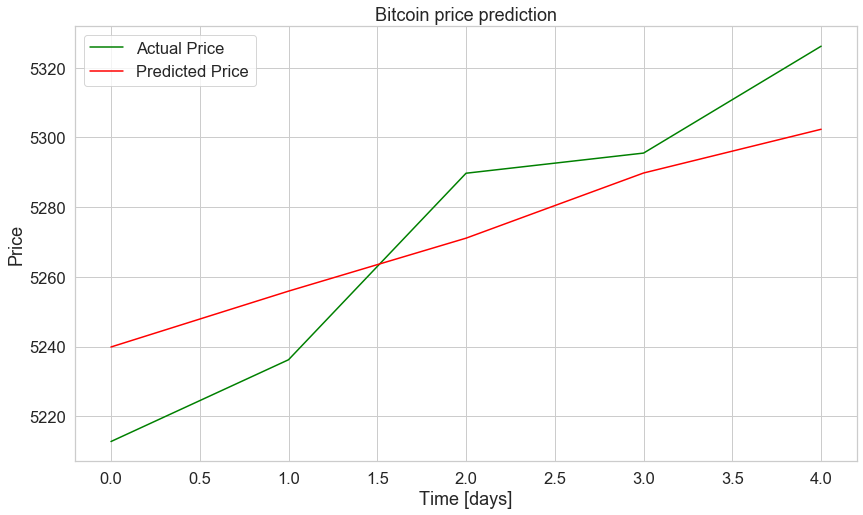

In [95]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

# 7- EVALUATING THE MODEL

Before any step , y_test and y_pred must be in same matrix size

In [136]:
y_test_inverse.shape

(5, 1)

In [137]:
y_hat_inverse.shape

(5, 1)

CALCULATE R^2 FOR TESTED DATA

In [138]:
from sklearn.metrics import r2_score

In [139]:
test_r2_score = r2_score(y_test_inverse,y_hat_inverse)

In [140]:
test_r2_score

0.7589840127092033

CALCULATE MSE FOR TESTED DATA

In [141]:
from sklearn.metrics import mean_squared_error
import math

In [142]:
test_MSE_score = math.sqrt(mean_squared_error(y_test_inverse,y_hat_inverse))

In [143]:
test_MSE_score

20.34263064085283